In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import src.utils as utils
import importlib
importlib.reload(utils)
import math
import ast

In [3]:
# x = towards sidelines
# y = towards baskets
# z = up/down

reading raw data BALL DATA - UTWN/UTWN15/UTWN15_FT_009.csv
    player    shot        vx  release_x_pm  release_x_poly        ax          vy  release_y_pm  release_y_poly       ay          vz  release_z_pm  release_z_poly          az  frame_start  frame_stop                                    sweet_spot_pm                                                 sweet_spot_poly    apex_t    apex_x      apex_y   apex_z_pm  apex_z_poly  entry_t_pm  entry_t_poly  entry_x_pm  entry_x_poly  entry_y_pm  entry_y_poly  entry_z_pm  entry_z_poly  dist_from_sweet_pm  dist_from_sweet_poly  release_v_mag_pm  release_v_mag_poly  launch_angle_pm  launch_angle_poly  off_center_angle_pm  off_center_angle_poly       vz_f  entry_angle_pm  entry_angle_poly entry_direction_pm entry_direction_poly  left_right_pm  left_right_poly  front_back_pm  front_back_poly short_long_pm short_long_poly  release_height_pm  release_height_poly  shot_distance_pm  shot_distance_poly
36  UTWN15  FT_009 -5.194032      3.212979        3

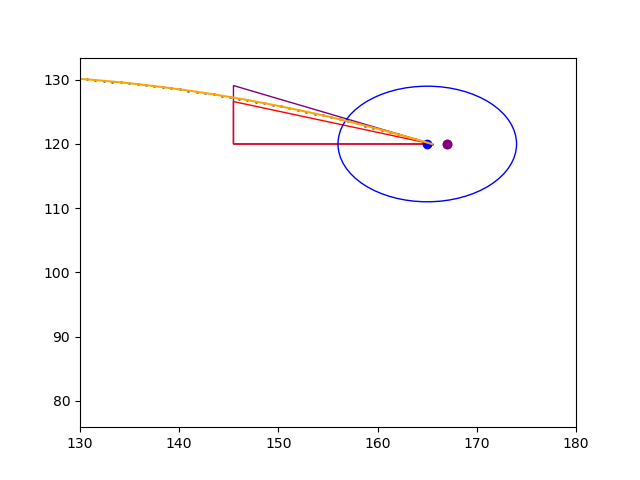

In [4]:
# plot side view of free throw going into basket
%matplotlib widget

player = f'UTWN15'
ft_num = '009'
time_series = pd.read_csv(f'out/{player}/FT_{ft_num}_TS.csv')
metrics = pd.read_csv(f'metrics/{player}/{player}_metrics.csv')
metrics = metrics[metrics['shot'] == f'FT_{ft_num}']
# units are in mm in raw file?
raw = pd.read_csv(f'BALL DATA - UTWN/{player}/{player}_FT_{ft_num}.csv', skiprows=3, nrows=100)
rim_center = utils.find_rim_coords(None, f'BALL DATA - UTWN/{player}/{player}_FT_{ft_num}.csv', False)

# extract just rim coords from raw data
rim_cols = [col for col in raw.columns if 'RIM6:Marker' in col]
raw = raw[rim_cols]
raw = raw.drop([0, 1, 2])
# convert raw data to inches
for col in raw.columns:
    raw[col] = raw[col].astype(float)
    raw[col] = raw[col].apply(utils.convert_mm_to_in)
rim_coords = raw.iloc[10].values
rim_coords = {
    1: [rim_coords[0], rim_coords[1], rim_coords[2]],
    2: [rim_coords[3], rim_coords[4], rim_coords[5]],
    3: [rim_coords[6], rim_coords[7], rim_coords[8]],
    4: [rim_coords[9], rim_coords[10], rim_coords[11]],
    5: [rim_coords[12], rim_coords[13], rim_coords[14]],
    6: [rim_coords[15], rim_coords[16], rim_coords[17]]
}

rim_coords = pd.DataFrame.from_dict(rim_coords, orient='index', columns=['x', 'y', 'z'])
print(metrics.head().to_string())

# plot y and z, side view of shot
fig, ax = plt.subplots()
ax.scatter(time_series['y'], time_series['z'], s=1)
# ax.scatter(rim_coords['y'], rim_coords['z'], c='green', label='Rim')

# Calculate the ball arc coordinates
release_x_pm = metrics['release_x_pm'].iloc[0]
release_y_pm = metrics['release_y_pm'].iloc[0]
release_z_pm = metrics['release_z_pm'].iloc[0]
release_x_poly = metrics['release_x_poly'].iloc[0]
release_y_poly = metrics['release_y_poly'].iloc[0]
release_z_poly = metrics['release_z_poly'].iloc[0]
entry_x_pm = metrics['entry_x_pm'].iloc[0]
entry_y_pm = metrics['entry_y_pm'].iloc[0]
entry_x_poly = metrics['entry_x_poly'].iloc[0]
entry_y_poly = metrics['entry_y_poly'].iloc[0]
vx = metrics['vx'].iloc[0]
vy = metrics['vy'].iloc[0]
vz = metrics['vz'].iloc[0]
acc_x = metrics['ax'].iloc[0]
ay = metrics['ay'].iloc[0]
az = metrics['az'].iloc[0]
left_right_pm = metrics['left_right_pm'].iloc[0]
left_right_poly = metrics['left_right_poly'].iloc[0]
sweetspot_pm = ast.literal_eval(metrics['sweet_spot_pm'].iloc[0])
sweetspot_poly = ast.literal_eval(metrics['sweet_spot_poly'].iloc[0])
entry_dir_pm = metrics['entry_direction_pm'].iloc[0]
entry_dir_poly = metrics['entry_direction_poly'].iloc[0]
front_back_pm = metrics['front_back_pm'].iloc[0]
front_back_poly = metrics['front_back_poly'].iloc[0]


# Generate time points
time_points = time_series['t']

# Calculate the ball arc
arc_x = release_x_pm + vx * time_points + 0.5 * acc_x * time_points**2
arc_y = release_y_pm + vy * time_points + 0.5 * ay * time_points**2
arc_z = release_z_pm + vz * time_points + 0.5 * -az * time_points**2


entry_angle_pm = metrics['entry_angle_pm'].iloc[0]
entry_angle_poly = metrics['entry_angle_poly'].iloc[0]
print('entry angle pm:', entry_angle_pm, 'entry angle poly:', entry_angle_poly)
# Plot the entry angle as a triangle so we can better see it
entry_angle_pm = math.radians(entry_angle_pm) 
entry_angle_poly = math.radians(entry_angle_poly)  
triangle_length = 20  # Length of the triangle edge

triangle_1 = [entry_x_poly, entry_y_poly, 120]
triangle_2 = [entry_x_poly, entry_y_poly - triangle_length, 120]
triangle_3_pm = [entry_x_poly, entry_y_poly - triangle_length, 120 + triangle_length * math.tan(entry_angle_pm)]
# only need to change the 3rd vertex for poly/pm
triangle_3_poly = [entry_x_poly, entry_y_poly - triangle_length, 120 + triangle_length * math.tan(entry_angle_poly)]
yz_verts_pm = [[t[1], t[2]] for t in [triangle_1, triangle_2, triangle_3_pm]]
yz_verts_poly = [[t[1], t[2]] for t in [triangle_1, triangle_2, triangle_3_poly]]
entry_tri = plt.Polygon(yz_verts_pm, closed=True, fill=None, edgecolor='red', label='Entry Angle PM')
entry_tri_poly = plt.Polygon(yz_verts_poly, closed=True, fill=None, edgecolor='purple', label='Entry Angle Poly')
ax.add_patch(entry_tri_poly)
ax.add_patch(entry_tri)
ax.set_xlim(130,180)

# ball arc y and z
ax.plot(arc_y, arc_z, label='Ball Arc', color='orange')
ax.scatter(rim_center[1], rim_center[2], c='blue', label='Rim Center')
ax.scatter(sweetspot_pm[1], sweetspot_pm[2], c='red', label='Sweet Spot PM')
ax.scatter(sweetspot_poly[1], sweetspot_poly[2], c='purple', label='Sweet Spot Poly')
circle = plt.Circle((rim_center[1], rim_center[2]), rim_center[3], color='blue', fill=False, label='Rim Circle')
ax.add_artist(circle)
plt.show()


[-0.11144774423862602, 167.00661567422304, 120]
entry point: -0.1856060574940686 165.4726847570724
left/right pm: -0.11 left/right poly: -0.11
front/back pm: -1.5320160121436015 front/back poly: -1.535384258738131


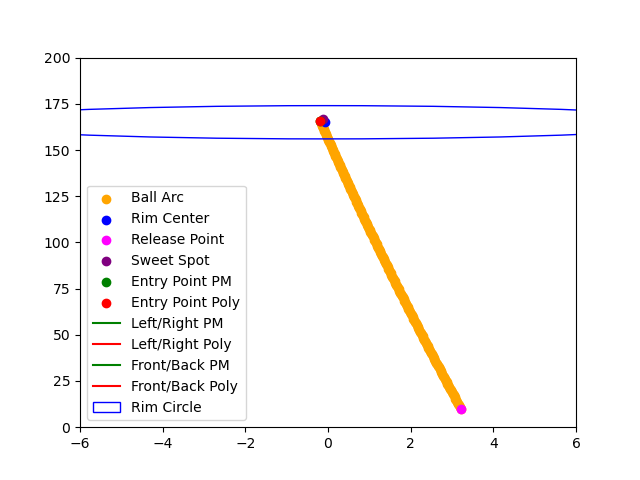

In [5]:
# plot overhead view of shot

sweetspot = ast.literal_eval(metrics['sweet_spot_pm'].iloc[0])
print(sweetspot)
fig, ax = plt.subplots()

# x and y of ball path
ax.scatter(time_series['x'], time_series['y'], s=1) # this is not shown in the output bc it's the same as arc_x and arc_y
ax.scatter(arc_x, arc_y, label='Ball Arc', color='orange')
ax.scatter(rim_center[0], rim_center[1], c='blue', label='Rim Center') # rim center
ax.scatter(metrics['release_x_pm'].iloc[0], metrics['release_y_pm'].iloc[0], c='magenta', label='Release Point')
ax.scatter(sweetspot[0], sweetspot[1], c='purple', label='Sweet Spot')
circle = plt.Circle((rim_center[0], rim_center[1]), rim_center[3], 
color='blue', fill=False, label='Rim Circle')

# entry points
print('entry point:', metrics['entry_x_pm'].iloc[0], metrics['entry_y_pm'].iloc[0])
ax.scatter(metrics['entry_x_pm'].iloc[0], metrics['entry_y_pm'].iloc[0], c='green', label='Entry Point PM', zorder=5)
ax.scatter(metrics['entry_x_poly'].iloc[0], metrics['entry_y_poly'].iloc[0], c='red', label='Entry Point Poly', zorder=5)

# left/right lines
print('left/right pm:', round(metrics['left_right_pm'].iloc[0], 2), 'left/right poly:', round(metrics['left_right_poly'].iloc[0], 2))
ax.plot([sweetspot[0], sweetspot[0] + left_right_pm], 
        [sweetspot[1], sweetspot[1]], c='green', label='Left/Right PM')
ax.plot([sweetspot[0], sweetspot[0] + left_right_poly],
        [sweetspot[1], sweetspot[1]], c='red', label='Left/Right Poly')
print(f'front/back pm:', metrics['front_back_pm'].iloc[0], 'front/back poly:', metrics['front_back_poly'].iloc[0])
ax.plot([sweetspot[0], sweetspot[0]],
        [sweetspot[1], sweetspot[1] + front_back_pm], c='green', label='Front/Back PM')
ax.plot([sweetspot[0], sweetspot[0]],
        [sweetspot[1], sweetspot[1] + front_back_poly], c='red', label='Front/Back Poly')


ax.add_artist(circle)
ax.set_xlim(-6, 6)
ax.set_ylim(0, 200)
ax.legend()
# ax.set_aspect('equal', adjustable='datalim')  # Ensure equal scaling

plt.show()

### generate grid of FTs for one player

In [7]:
%matplotlib widget

player_type = 'UTWN'
player_num = '15'
player = f'{player_type}{player_num}'
metrics = pd.read_csv(f'metrics/{player}/{player}_metrics.csv')
ft_nums = metrics['shot'].unique()
ft_nums = sorted(ft_nums)
print(f'len ft_nums:', len(ft_nums))
rows, cols = 7,8
fig, axes = plt.subplots(rows, cols, figsize=(20, 20), dpi=300) # side view
fig_over, axes_over = plt.subplots(rows, cols, figsize=(20, 20), dpi=300) # overhead view

for i, ft_num in enumerate(ft_nums):
    row,col = divmod(i, cols)
    ax = axes[row, col]
    time_series = pd.read_csv(f'out/{player}/{ft_num}_TS.csv')
    shot_metrics = metrics[metrics['shot'] == ft_num]
    # units are in mm in raw file?
    raw_path = f'/Volumes/michsand256/kait_data/BALL DATA - {player_type}/{player}/{player}_{ft_num}.csv'
    # raw_path = f'BALL DATA - {player_type}/{player}/{player}_{ft_num}.csv'
    raw = pd.read_csv(raw_path, skiprows=3, nrows=100)
    rim_center = utils.find_rim_coords(None, raw_path, False) # 0 = x center, 1 = y, 2 = z, 3 = radius

    # extract just rim coords from raw data
    rim_cols = [col for col in raw.columns if 'RIM6:Marker' in col]
    if len(rim_cols) == 0:
        rim_cols = [col for col in raw.columns if 'Rim:Marker' in col]
    raw = raw[rim_cols]
    raw = raw.drop([0, 1, 2])
    # convert raw data to inches
    for c in raw.columns:
        raw[c] = raw[c].astype(float)
        raw[c] = raw[c].apply(utils.convert_mm_to_in)
    rim_coords = raw.iloc[10].values
    rim_coords = {
        1: [rim_coords[0], rim_coords[1], rim_coords[2]],
        2: [rim_coords[3], rim_coords[4], rim_coords[5]],
        3: [rim_coords[6], rim_coords[7], rim_coords[8]],
        4: [rim_coords[9], rim_coords[10], rim_coords[11]],
        5: [rim_coords[12], rim_coords[13], rim_coords[14]],
        6: [rim_coords[15], rim_coords[16], rim_coords[17]]
    }

    rim_coords = pd.DataFrame.from_dict(rim_coords, orient='index', columns=['x', 'y', 'z'])
    # print(metrics.head().to_string())

    # plot y and z, side view of shot
    ax.scatter(time_series['y'], time_series['z'], s=1)
    # ax.scatter(rim_center[1], rim_center[2], c='green', label='Rim')

    # Calculate the ball arc coordinates
    release_x_pm = shot_metrics['release_x_pm'].iloc[0]
    release_y_pm = shot_metrics['release_y_pm'].iloc[0]
    release_z_pm = shot_metrics['release_z_pm'].iloc[0]
    release_x_poly = shot_metrics['release_x_poly'].iloc[0]
    release_y_poly = shot_metrics['release_y_poly'].iloc[0]
    release_z_poly = shot_metrics['release_z_poly'].iloc[0]
    entry_x_pm = shot_metrics['entry_x_pm'].iloc[0]
    entry_y_pm = shot_metrics['entry_y_pm'].iloc[0]
    entry_x_poly = shot_metrics['entry_x_poly'].iloc[0]
    entry_y_poly = shot_metrics['entry_y_poly'].iloc[0]
    vx = shot_metrics['vx'].iloc[0]
    vy = shot_metrics['vy'].iloc[0]
    vz = shot_metrics['vz'].iloc[0]
    acc_x = shot_metrics['ax'].iloc[0]
    ay = shot_metrics['ay'].iloc[0]
    az = shot_metrics['az'].iloc[0]
    left_right_pm = shot_metrics['left_right_pm'].iloc[0]
    left_right_poly = shot_metrics['left_right_poly'].iloc[0]
    sweetspot_pm = ast.literal_eval(shot_metrics['sweet_spot_pm'].iloc[0])
    sweetspot_poly = ast.literal_eval(shot_metrics['sweet_spot_poly'].iloc[0])
    entry_dir_pm = shot_metrics['entry_direction_pm'].iloc[0]
    entry_dir_poly = shot_metrics['entry_direction_poly'].iloc[0]
    front_back_pm = shot_metrics['front_back_pm'].iloc[0]
    front_back_poly = shot_metrics['front_back_poly'].iloc[0]
    entry_angle_pm = shot_metrics['entry_angle_pm'].iloc[0]
    entry_angle_poly = shot_metrics['entry_angle_poly'].iloc[0]


    # Generate time points
    time_points = time_series['t']

    # Calculate the ball arc
    arc_x = release_x_pm + vx * time_points + 0.5 * acc_x * time_points**2
    arc_y = release_y_pm + vy * time_points + 0.5 * ay * time_points**2
    arc_z = release_z_pm + vz * time_points + 0.5 * -az * time_points**2


    # print('entry angle pm:', entry_angle_pm, 'entry angle poly:', entry_angle_poly)
    # Plot the entry angle as a triangle so we can better see it
    entry_angle_pm = math.radians(entry_angle_pm) 
    entry_angle_poly = math.radians(entry_angle_poly)  
    triangle_length = 20  # Length of the triangle edge

    triangle_1 = [entry_x_poly, entry_y_poly, 120]
    triangle_2 = [entry_x_poly, entry_y_poly - triangle_length, 120]
    triangle_3_pm = [entry_x_poly, entry_y_poly - triangle_length, 120 + triangle_length * math.tan(entry_angle_pm)]
    # only need to change the 3rd vertex for poly/pm
    triangle_3_poly = [entry_x_poly, entry_y_poly - triangle_length, 120 + triangle_length * math.tan(entry_angle_poly)]
    yz_verts_pm = [[t[1], t[2]] for t in [triangle_1, triangle_2, triangle_3_pm]]
    yz_verts_poly = [[t[1], t[2]] for t in [triangle_1, triangle_2, triangle_3_poly]]
    entry_tri = plt.Polygon(yz_verts_pm, closed=True, fill=None, edgecolor='red', label='Entry Angle PM')
    entry_tri_poly = plt.Polygon(yz_verts_poly, closed=True, fill=None, edgecolor='purple', label='Entry Angle Poly')
    ax.add_patch(entry_tri_poly)
    ax.add_patch(entry_tri)
    ax.set_xlim(130,180)

    # ball arc y and z
    ax.plot(arc_y, arc_z, label='Ball Arc', color='orange')
    ax.scatter(rim_center[1], rim_center[2], c='blue', label='Rim Center')
    ax.scatter(sweetspot_pm[1], sweetspot_pm[2], c='red', label='Sweet Spot PM')
    ax.scatter(sweetspot_poly[1], sweetspot_poly[2], c='purple', label='Sweet Spot Poly')
    # circle = plt.Circle((rim_center[1], rim_center[2]), rim_center[3], color='blue', fill=False, label='Rim Circle')
    # ax.add_artist(circle)
    ax.plot([rim_center[1] - rim_center[3], rim_center[1] + rim_center[3]],
            [rim_center[2], rim_center[2]], c='green', label='Rim')
    ax.set_title(ft_num, fontsize=10)
    

    # START overhead view of shot
    ax_over = axes_over[row, col]
    ax_over.set_title(ft_num, fontsize=10)

    # x and y of ball path
    ax_over.scatter(time_series['x'], time_series['y'], s=1) # this is not shown in the output bc it's the same as arc_x and arc_y
    ax_over.scatter(arc_x, arc_y, label='Ball Arc', color='orange')
    ax_over.scatter(rim_center[0], rim_center[1], c='blue', label='Rim Center') # rim center
    ax_over.scatter(shot_metrics['release_x_pm'].iloc[0], shot_metrics['release_y_pm'].iloc[0], c='magenta', label='Release Point')
    ax_over.scatter(sweetspot_poly[0], sweetspot_poly[1], c='grey', label='Sweet Spot Poly')
    ax_over.scatter(sweetspot_pm[0], sweetspot_pm[1], c='purple', label='Sweet Spot PM')
    circle = plt.Circle((rim_center[0], rim_center[1]), rim_center[3], 
    color='blue', fill=False, label='Rim Circle')

    # entry points
    ax_over.scatter(shot_metrics['entry_x_pm'].iloc[0], shot_metrics['entry_y_pm'].iloc[0], c='green', label='Entry Point PM', zorder=5)
    ax_over.scatter(shot_metrics['entry_x_poly'].iloc[0], shot_metrics['entry_y_poly'].iloc[0], c='red', label='Entry Point Poly', zorder=5)

    # left/right lines
    ax_over.plot([rim_center[0], rim_center[0] + left_right_pm], 
            [rim_center[1], rim_center[1]], c='green', label='Left/Right PM')
    ax_over.plot([rim_center[0], rim_center[0] + left_right_poly],
            [rim_center[1], rim_center[1]], c='red', label='Left/Right Poly')
    ax_over.plot([rim_center[0], rim_center[0]],
            [rim_center[1], rim_center[1] + front_back_pm], c='green', label='Front/Back PM')
    ax_over.plot([rim_center[0], rim_center[0]],
            [rim_center[1], rim_center[1] + front_back_poly], c='red', label='Front/Back Poly')

    ax_over.add_artist(circle)
    ax_over.set_xlim(-6, 6)
    ax_over.set_ylim(0, 200)
    # ax_over.legend()
    # ax.set_aspect('equal', adjustable='datalim')  # Ensure equal scaling


plt.tight_layout(rect=[0, 0, 1, 0.99])  # Leave space for title
os.makedirs('output_images', exist_ok=True)
fig.suptitle(f'Free Throw Analysis - {player}', fontsize=16, y=.97)
fig.subplots_adjust(hspace=0.4)  # Increase vertical spacing between rows
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=12, bbox_to_anchor=(0.5, 0.94))
fig.savefig(f'output_images/{player}side_views.png', bbox_inches='tight')

fig_over.suptitle(f'Free Throw Analysis - {player}', fontsize=16, y=.97)
handles, labels = axes_over[0,0].get_legend_handles_labels()
fig_over.legend(handles, labels, loc='upper center', ncol=5, fontsize=12, bbox_to_anchor=(0.5, 0.96))
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leaves space at the bottom for legend
fig_over.savefig(f'output_images/{player}_overhead_views.png', bbox_inches='tight')
plt.close()


len ft_nums: 40


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/michsand256/kait_data/BALL DATA - UTWN/UTWN15/UTWN15_FT_001.csv'